In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np

In [3]:
from fastai.imports import *
from fastai.vision import *

In [4]:
os.environ['CUDA_DEVICE_ORDER']="PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES']='0'
torch.cuda.set_device(0)

In [5]:
torch.cuda.empty_cache()
torch.cuda.current_device()

0

In [6]:
#set seed
np.random.seed(2)

In [7]:
data = ImageDataBunch.from_folder(path = './classifier-images/imageset_divided/', 
                                  train = 'train', valid = 'validation', 
                                  ds_tfms=get_transforms(do_flip=False), size=128)
data


ImageDataBunch;

Train: LabelList (3050 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
edge,edge,edge,edge,edge
Path: classifier-images/imageset_divided;

Valid: LabelList (1018 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
edge,edge,edge,edge,edge
Path: classifier-images/imageset_divided;

Test: None

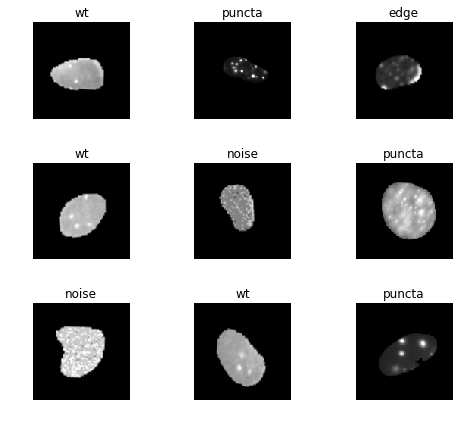

In [8]:
data.show_batch(rows=3,figsize=(7,6))

In [9]:
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (3050 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
edge,edge,edge,edge,edge
Path: classifier-images/imageset_divided;

Valid: LabelList (1018 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
edge,edge,edge,edge,edge
Path: classifier-images/imageset_divided;

Test: None

In [10]:
learn_18 = cnn_learner(data, models.resnet34, metrics=accuracy)

In [11]:
learn_18.fit_one_cycle(6)

epoch,train_loss,valid_loss,accuracy,time
0,0.634292,0.249148,0.918468,00:04
1,0.393824,0.195375,0.931238,00:04
2,0.281346,0.168487,0.942043,00:04
3,0.230645,0.169066,0.933202,00:04
4,0.189592,0.143448,0.947937,00:04
5,0.164855,0.145505,0.950884,00:04


In [12]:
interp = ClassificationInterpretation.from_learner(learn_18)

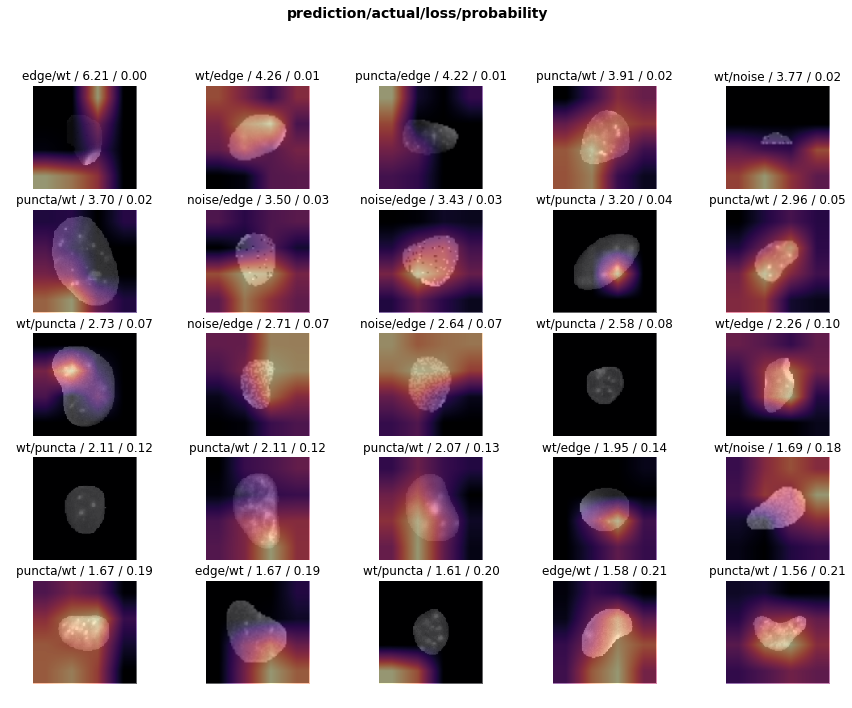

In [13]:
interp.plot_top_losses(25,figsize=(15,11))

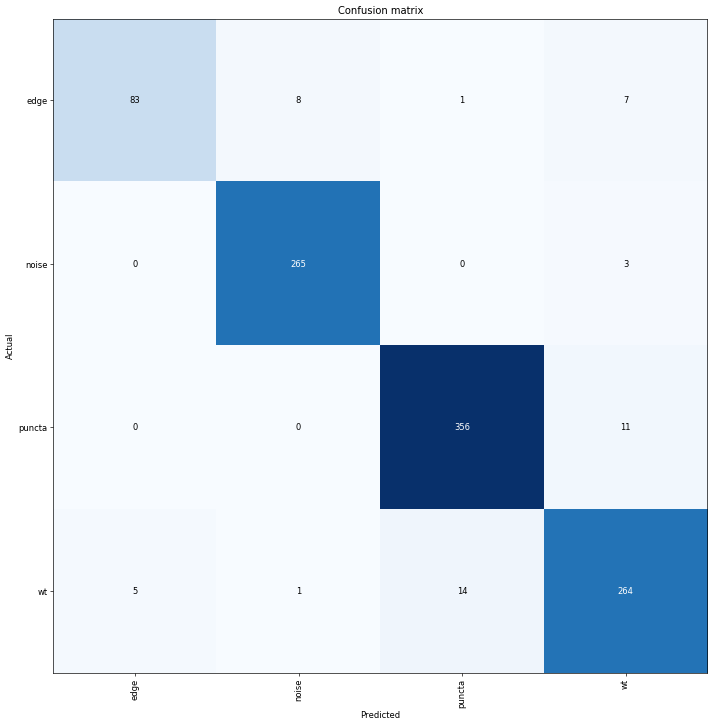

In [14]:
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

In [52]:
learn_18.save('stage-1-resnet34')

In [15]:
learn_18.unfreeze()

In [16]:
learn_18.fit_one_cycle(10)

epoch,train_loss,valid_loss,accuracy,time
0,0.179866,0.157345,0.948919,00:05
1,0.227799,0.381112,0.909627,00:04
2,0.211056,0.190331,0.943026,00:04
3,0.183498,0.135272,0.954813,00:05
4,0.158632,0.135342,0.951866,00:04
5,0.139274,0.185149,0.945973,00:04
6,0.131303,0.154158,0.943026,00:05
7,0.107103,0.122270,0.962672,00:05
8,0.081683,0.131300,0.959725,00:04
9,0.060718,0.133972,0.958743,00:04


In [17]:
learn_18.save('classifier-resnet34-noise')

In [18]:
learn_18.export('export.pkl')

In [29]:
learn.save('stage-2-resnet34')

In [30]:
learn_18.unfreeze()

In [31]:
learn_18.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,time
0,0.031707,0.090265,0.969765,00:26


In [32]:
learn_18.save('stage-2-resnet18')

In [6]:
###### test
import time
export_path = '/home/srirampendyala/Projects/U2OS-LMNA/crops/jpegs_titration/'
conc = [0, 7, 8, 10, 20]
classes = ['puncta', 'normal']
variants = ['WT', 'N195K', 'Library']
times = ['18_hour', '23_hour', '27_hour', '32_hour']
filters = [0, 500, 1000, 2500, 5000]

for lib in libs:
    crop_path = '/home/srirampendyala/Projects/U2OS-LMNA/crops/jpegs_titration_filter/' + lib + '/'
    all_tables = []
    for t in times:
        tables = []
        test_path1 = os.path.join(crop_path, t)
        for variant in variants:
            table = []
            test_path2 = os.path.join(test_path1, variant)
            for i in range(len(conc)):
                start = time.time()
                test_path = os.path.join(test_path2,str(conc[i]))
                learn = load_learner(export_path, test = ImageList.from_folder(test_path))
                preds, _ = learn.get_preds(ds_type=DatasetType.Test)
                pred_prob, pred_class = preds.max(1)
                print(pd.Series([classes[int(i)] for i in pred_class]).value_counts().sort_index())
                table.append(pd.Series([classes[int(i)] for i in pred_class]).value_counts(normalize=True).sort_index().tolist())
                print(time.time() - start, len(pred_class))
            tables.append(table)
        all_tables.append(tables)
    name = 'all_tables_intensity_' + lib + '.pickle'
    pickle.dump(all_tables, open('./output/titration-output/' + name, 'wb'))


normal    2039
puncta     350
dtype: int64
3.0562899112701416 2389


In [49]:
all_tables[0][0][3] = [1.0, 0.0]

In [58]:
np.asarray(all_tables).shape

(4, 4, 5, 2)

In [59]:
np.asarray(all_tables[0]).shape

(4, 5, 2)

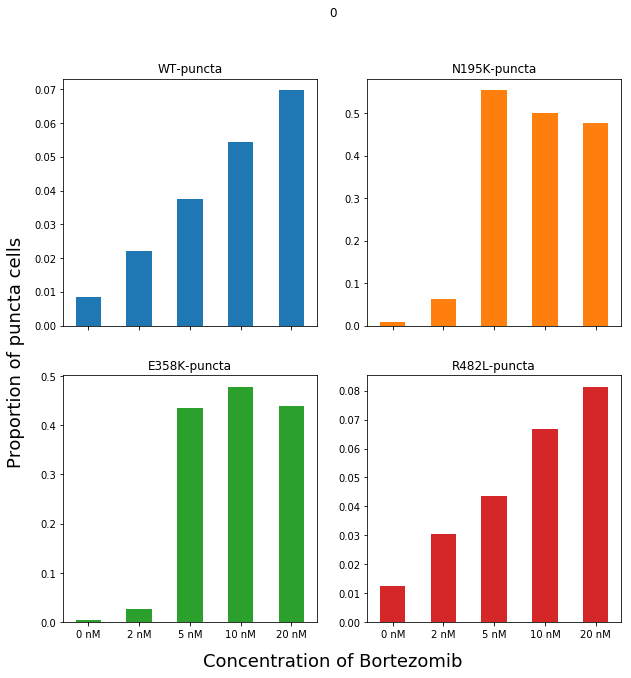

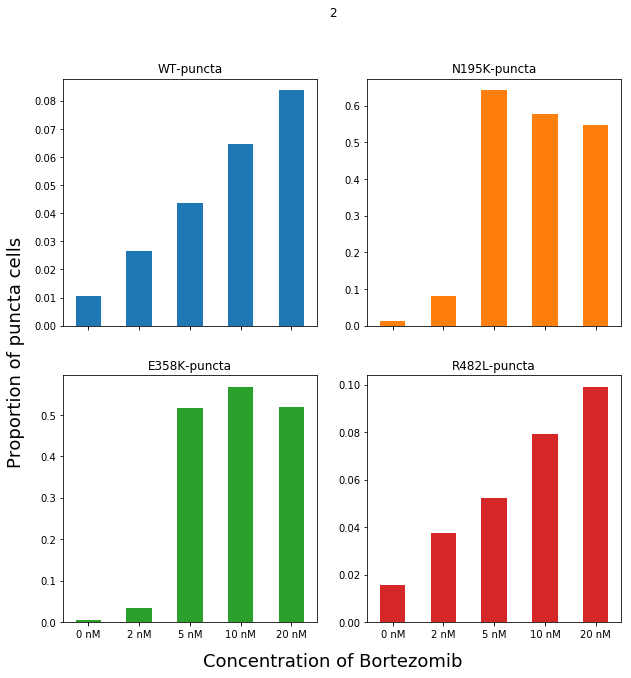

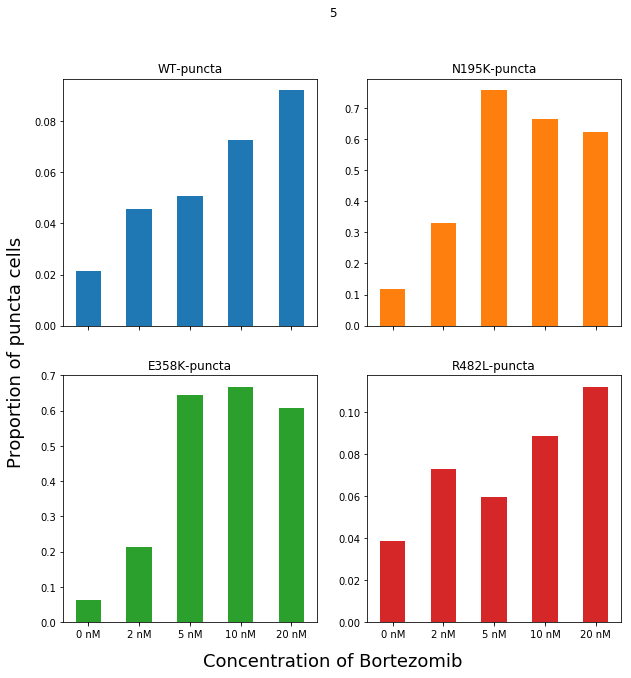

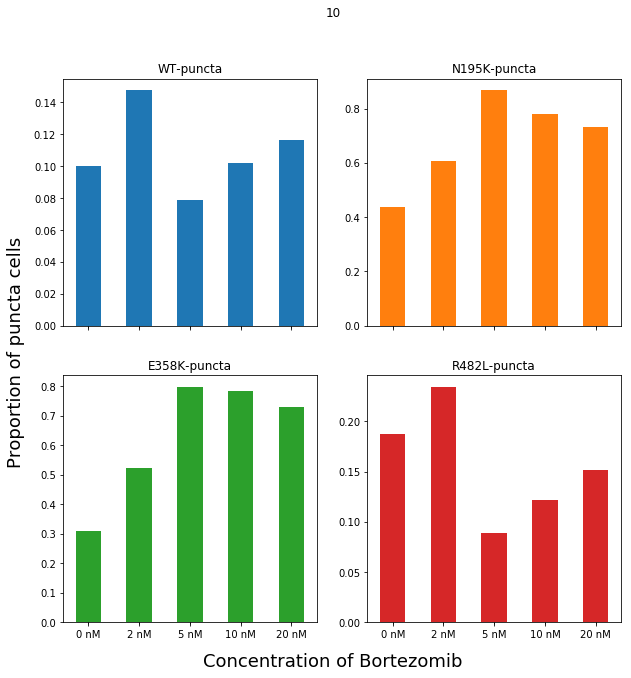

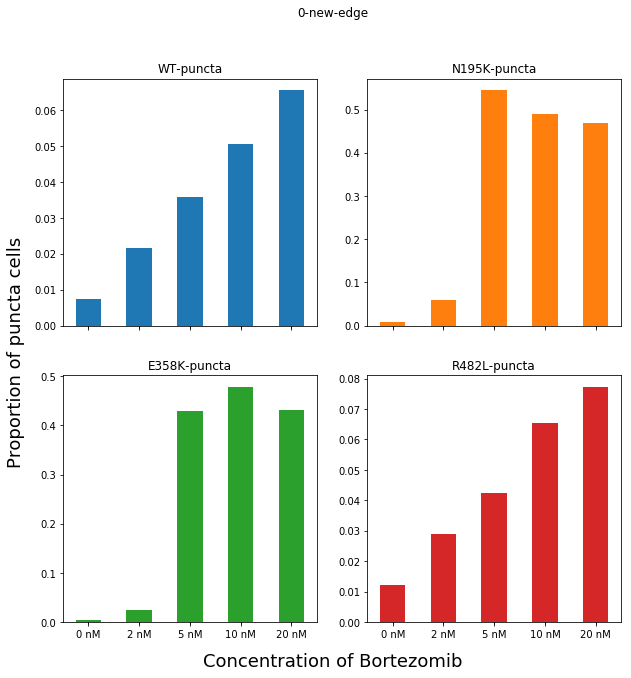

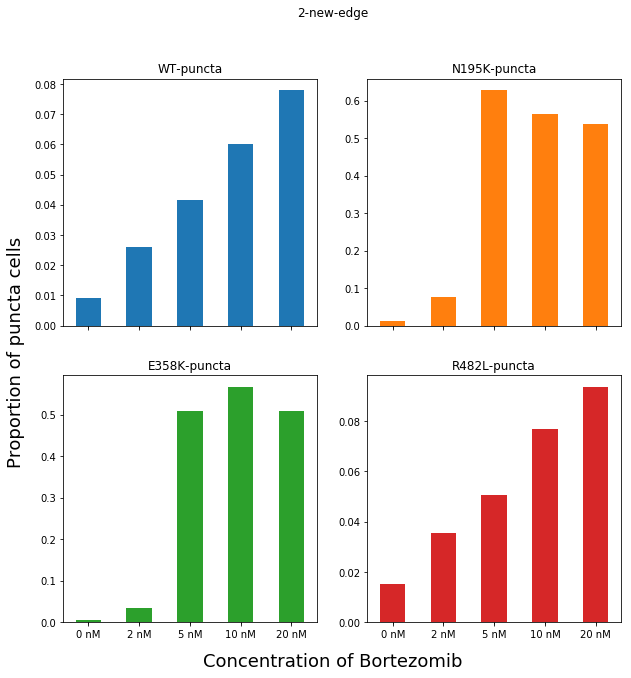

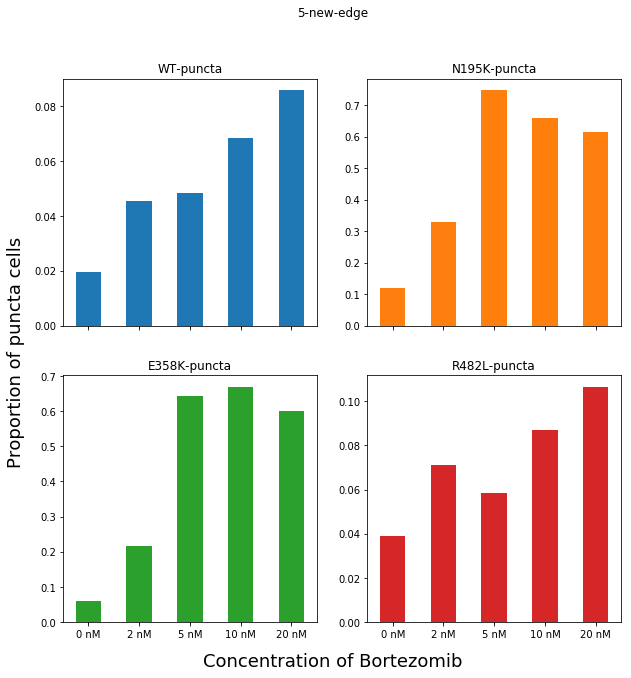

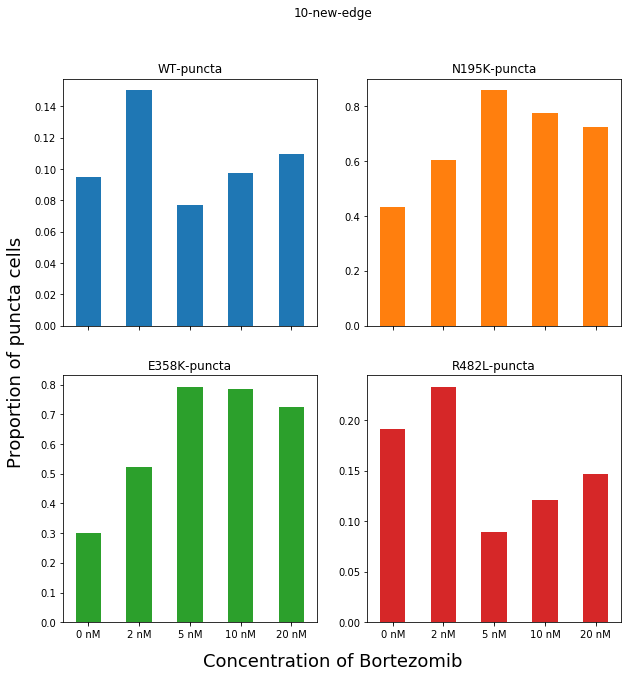

In [12]:
## load tables
libs = ['0', '2', '5', '10', '0-new-edge', '2-new-edge', '5-new-edge', '10-new-edge']
conc = ['0 nM', '2 nM', '5 nM', '10 nM', '20 nM']
classes = ['puncta', 'normal']
variants = ['WT', 'N195K', 'E358K', 'R482L']
times = ['1_hour', '8_hour', '16_hour', '23_hour']
tables = {}
for lib in libs:
    name = 'all_tables_intensity_' + lib + '.pickle'
    tables[lib] = pickle.load(open('./output/titration-output/' + name, 'rb'))
    all_tables = tables[lib]
    
    times = [1, 8, 16, 23]
    j = 0
    dfs = []
    for timeTab in all_tables:
        i = 0
        timeTab = np.asarray(timeTab)
        for tab in timeTab:
            tab = np.asarray(tab)
            temp = pd.DataFrame({variants[i] + '-' + 'puncta': tab[:,1]})
            if i == 0:
                df = temp
            else :
                df = pd.concat([df, temp], axis=1)
            i+=1
        df = pd.concat([df, pd.DataFrame({'Time': np.ones(timeTab.shape[1])*times[j]})], axis=1)
        df = df.rename(index={0: conc[0], 1:conc[1], 2:conc[2], 3:conc[3], 4:conc[4]})
        j+=1
        dfs.append(df)

        
    df_sub = getSubsetDf(time = 23)
        
    axes = df_sub.plot.bar(rot=0, subplots=True, layout=(2,2), figsize=(10,10), legend=False, )

    if df_sub.index.dtype == 'float64':
        xlabel = 'Time (hrs)'
    else :
        xlabel = 'Concentration of Bortezomib'

    fig=axes[0,0].figure
    fig.suptitle(lib, fontsize=12)
    fig.text(0.5,0.07, xlabel, ha="center", va="center", size = 18)
    fig.text(0.06,0.5, "Proportion of puncta cells", ha="center", va="center", rotation=90, size = 18)

dict_keys(['0', '2', '5', '10', '0-new-edge', '2-new-edge', '5-new-edge', '10-new-edge'])

In [10]:
times = [1, 8, 16, 23]
j = 0
dfs = []
for timeTab in all_tables:
    i = 0
    timeTab = np.asarray(timeTab)
    for tab in timeTab:
        tab = np.asarray(tab)
        temp = pd.DataFrame({variants[i] + '-' + 'puncta': tab[:,1]})
        if i == 0:
            df = temp
        else :
            df = pd.concat([df, temp], axis=1)
        i+=1
    df = pd.concat([df, pd.DataFrame({'Time': np.ones(timeTab.shape[1])*times[j]})], axis=1)
    df = df.rename(index={0: conc[0], 1:conc[1], 2:conc[2], 3:conc[3], 4:conc[4]})
    j+=1
    dfs.append(df)

In [39]:
## over time; constant conc.
def getSubsetDf(conc = None, time = None):
    df_sub = None
    if conc is not None:
        for df in dfs:
            temp = df.loc[conc]
            temp.name = temp['Time']
            temp = temp.drop(index = 'Time')
            if df_sub is None:
                df_sub = temp
            else :
                df_sub = pd.concat([df_sub, temp], axis=1)
        df_sub = df_sub.T
        df_sub = df_sub.rename(index={1:0, 8:8, 16:16, 23:24})
    elif time is not None:
        times = [1, 8, 16, 23]
        df_sub = dfs[times.index(time)].drop(columns = 'Time')
    return df_sub
    

In [40]:
#df_sub = getSubsetDf(time = 23)
df_sub = getSubsetDf(conc = '5 nM')

Text(0.06, 0.5, 'Proportion of puncta cells')

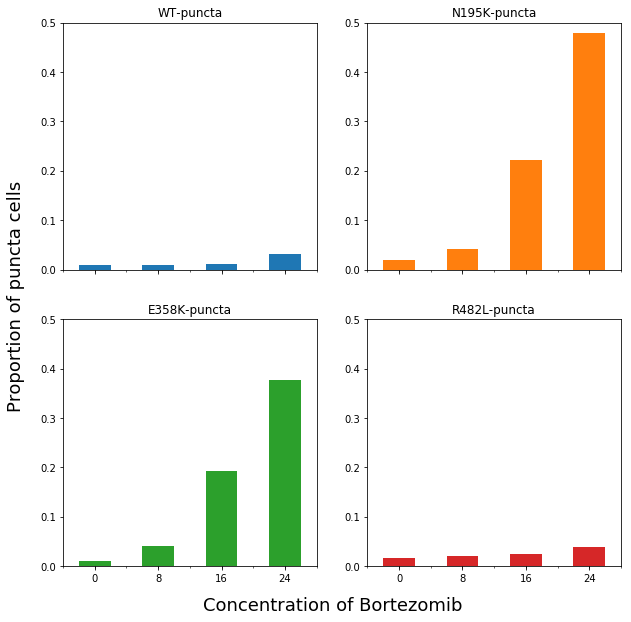

In [41]:
axes = df_sub.plot.bar(rot=0, subplots=True, layout=(2,2), figsize=(10,10), legend=False)

if df_sub.index.dtype == 'float64':
    xlabel = 'Time (hrs)'
else :
    xlabel = 'Concentration of Bortezomib'
    
for i in range(axes.shape[0]):
    for j in range(axes.shape[1]):
        axes[i,j].set_ylim((0,0.5))
        
fig=axes[0,0].figure
#plt.ylim((0,0.5))
fig.text(0.5,0.07, xlabel, ha="center", va="center", size = 18)
fig.text(0.06,0.5, "Proportion of puncta cells", ha="center", va="center", rotation=90, size = 18)

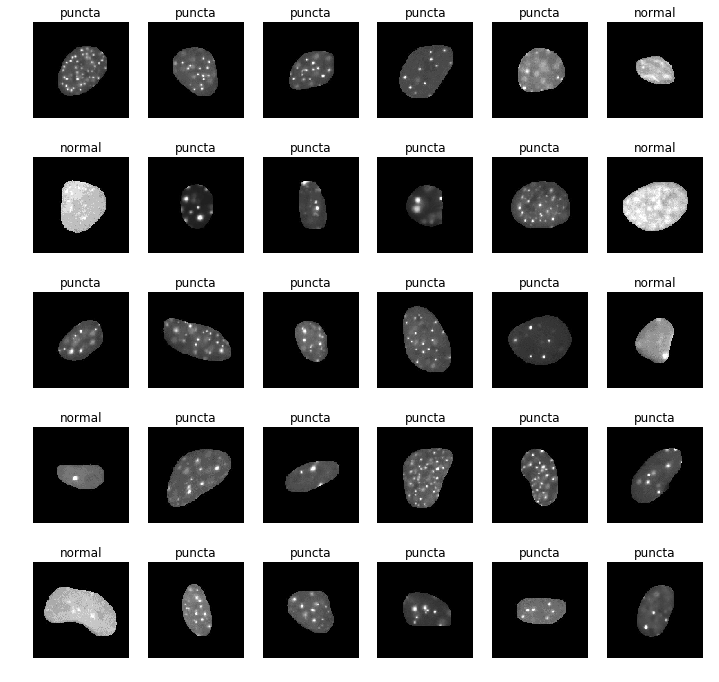

In [65]:
variant = 'N195K'
c = '5 nM'

test_path2 = os.path.join(test_path1, variant)


start = time.time()
test_path = os.path.join(test_path2,str(c))
learn = load_learner(export_path, test = ImageList.from_folder(test_path))
preds, _ = learn.get_preds(ds_type=DatasetType.Test)
pred_prob, pred_class = preds.max(1)


fig=plt.figure(figsize=(12, 12))
columns = 6
rows = 5
ax = []
classes = ['puncta', 'normal']
labels = [classes[int(i)] for i in pred_class]
images = ImageList.from_folder(test_path)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for i in range(1, (columns*rows)+1): #(columns*rows // 2)+1):

        ax.append(fig.add_subplot(rows, columns, i)) #(2*i - 1)))

        img = np.asarray(images[i-1].data)[0,:,:]
        plt.imshow(img, cmap='gray')
        plt.title(labels[i-1])
        plt.axis('off')


plt.show()

<Figure size 1296x1152 with 0 Axes>

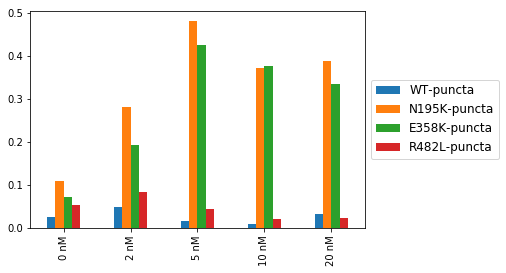

In [24]:
df_sub = df[df.columns[[1,3,5,7]]]
fig = plt.figure(figsize = (18,16))
df_sub.plot.bar()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 12})

In [60]:
name = 'all_tables_intensity-5-new-edge.pickle'
pickle.dump(all_tables, open('./output/titration-output/' + name, 'wb'))

In [9]:
#### titration no filters
###### test
import time, os
export_path = '/home/srirampendyala/Projects/U2OS-LMNA/crops/jpegs_titration/'
classes = ['puncta', 'normal']
conc = ['0 nM', '2 nM', '5 nM', '10 nM', '20 nM']
variants = ['WT', 'N195K', 'E358K', 'R482L']
times = ['1_hour', '8_hour', '16_hour', '23_hour']

crop_path = '/home/srirampendyala/Projects/U2OS-LMNA/crops/jpegs_titration_nofilter/'
all_tables = []
for t in times:
    tables = []
    test_path1 = os.path.join(crop_path, t)
    for variant in variants:
        table = []
        test_path2 = os.path.join(test_path1, variant)
        for i in range(len(conc)):
            start = time.time()
            test_path = os.path.join(test_path2,str(conc[i]))
            learn = load_learner(export_path, test = ImageList.from_folder(test_path))
            preds, _ = learn.get_preds(ds_type=DatasetType.Test)
            pred_prob, pred_class = preds.max(1)
            print(pd.Series([classes[int(i)] for i in pred_class]).value_counts().sort_index())
            table.append(pd.Series([classes[int(i)] for i in pred_class]).value_counts(normalize=True).sort_index().tolist())
            print(time.time() - start, len(pred_class))
        tables.append(table)
    all_tables.append(tables)
name = 'all_tables_nofilter.pickle'
pickle.dump(all_tables, open('./output/titration-output/' + name, 'wb'))


normal    8136
puncta     408
dtype: int64
9.906718254089355 8544


In [7]:
###### resetz
import time
export_path = '/home/srirampendyala/Projects/U2OS-LMNA/crops/jpegs_titration/'
crop_path = '/home/srirampendyala/Projects/U2OS-LMNA/crops/jpegs_resetz_nofilter/'
variants = ['WT', 'E145K', 'N195K', 'E358K', 'R386K', 'R482L']
classes = ['puncta', 'normal']

table = []
for variant in variants:
    test_path = os.path.join(crop_path, variant)
    start = time.time()
    learn = load_learner(export_path, test = ImageList.from_folder(test_path))
    preds, _ = learn.get_preds(ds_type=DatasetType.Test)
    pred_prob, pred_class = preds.max(1)
    print(pd.Series([classes[int(i)] for i in pred_class]).value_counts().sort_index())
    table.append(pd.Series([classes[int(i)] for i in pred_class]).value_counts(normalize=True).sort_index().tolist())

#pickle.dump(table, open('./output/inception_outputs/classifier.pkl', 'wb'))


normal    784
puncta    108
dtype: int64


In [8]:
## load tables

classes = ['puncta', 'normal']
variants = ['WT', 'E145K', 'N195K', 'E358K', 'R386K', 'R482L']

table = np.asarray(table)
df = pd.DataFrame({'Puncta':table[:,1]})
df = df.rename(index={0: variants[0], 1:variants[1], 2:variants[2], 3:variants[3], 4:variants[4], 5:variants[5]})

df

,Puncta
WT,0.119643
E145K,0.024116
N195K,0.546336
E358K,0.503141
R386K,0.182302
R482L,0.121076


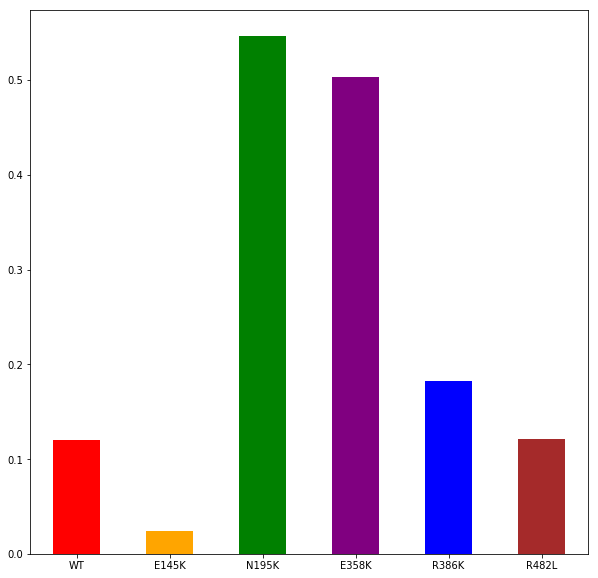

In [9]:
number_of_colors = 6
np.random.seed(110)

color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(number_of_colors)]


axes = df['Puncta'].plot.bar(rot=0, subplots=True, layout=(1,1), figsize=(10,10), color = tuple(['r', 'orange', 'g', 'purple', 'b', 'brown']),
                            label = '')

fig=axes[0,0].figure
